# Laboratory Seven

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
import numpy as np
import scipy.linalg as la
from qiskit.visualization import plot_histogram

The noise model that we are going to use is:

In [3]:
def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model


We will start our exploration with 2 qubits. For each possible combination of qubits we will perform a large number of measurements, in this case 10,000, using the noise model. There are 4 possible combinations of qubit values, so this is relatively easy. The code for doing this is:

In [6]:
noise_model = get_noise(0.01)

for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure(qc.qregs[0],qc.cregs[0])
    print(state+' becomes',
          execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

00 becomes {'00': 9773, '01': 118, '10': 108, '11': 1}
01 becomes {'00': 98, '01': 9820, '10': 1, '11': 81}
10 becomes {'00': 119, '10': 9801, '11': 80}
11 becomes {'00': 1, '01': 93, '10': 105, '11': 9801}


Note that we get the correct result over 97% of the time. This is what we would expect with the fairly low error probability. We also notice that 2 qubit errors occur very rarely, if not at all. The vast majority of the errors are 1 qubit errors.

Try one more example before we start building our model. If we have something like the Bell state, we have two correct answers. Let’s give that a try:

In [8]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

{'00': 4924, '01': 102, '10': 93, '11': 4881}


Again, the two correct answers are the ones with the highest probability, but there is still a chance that we could get an incorrect answer.

All term we’ve taken the result with the highest number of counts as the correct one. For simple programs that has worked well, but we would like something more formal for more complicated programs.

#### Mitigation Algorithm

Our first experiment essentially took ideal results and produced a vector of measured results. That is, it mapped from the correct result to the measured result. For each of the 4 possible qubit combinations we got a vector of 4 measurements. We have 16 values, which suggests that we could put our results into a 4x4 matrix.

Rearranging our first vector of results to be in |00>, |01>, |10> and |11> order we have the following after we normalize the counts:



$$\begin{pmatrix}0.9773 \\0.0118 \\0.0108 \\0.0001
\end{pmatrix}$$

We can do the same thing with the other three sets of results to form a complete matrix. This gives us the following Python code:

In [17]:
M = [[0.9773,0.0098,0.0119,0.0001],
    [0.0118,0.9820,0.0000,0.0081],
    [0.0108,0.0001,0.9801,0.0105],
    [0.0001,0.0081,0.0080,0.9801]]

Cideal = [[5000],
          [0],
          [0],
          [5000]]

Cnoisy = np.dot(M, Cideal)

print('If we take the correct result and multiply it by this matrix, we will get something close to the last experiment in the previous section. The result that we get from this code is: \n')

print('C_noisy =\n',Cnoisy)

print('\nThis is pretty close to the result that we got before. But what we really want is the opposite, we want to go from measured results to the correct results. Now that we have the matrix M, we only need to invert this matrix to get what we want. The Python code for doing this is:\n')

If we take the correct result and multiply it by this matrix, we will get something close to the last experiment in the previous section. The result that we get from this code is: 

C_noisy =
 [[4887. ]
 [  99.5]
 [ 106.5]
 [4901. ]]

This is pretty close to the result that we got before. But what we really want is the opposite, we want to go from measured results to the correct results. Now that we have the matrix M, we only need to invert this matrix to get what we want. The Python code for doing this is:



In [19]:
Minv = la.inv(M)

print(Minv)

print('')

print('\nWhen we apply this matrix, we get the following result:')

[[ 1.02348791e+00 -1.02137016e-02 -1.24277228e-02  1.13124458e-04]
 [-1.22992672e-02  1.01852210e+00  2.18049416e-04 -8.41861912e-03]
 [-1.12778052e-02  9.88036351e-05  1.02053022e+00 -1.09328026e-02]
 [ 8.92742732e-05 -8.41730238e-03 -8.33054299e-03  1.02046285e+00]]


When we apply this matrix, we get the following result:


In [11]:
Cmeasured = [4900, 104, 98, 4898]

Cmitigated = np.dot(Minv, Cmeasured)
print('C_mitigated =\n',Cmitigated)

C_mitigated =
 [ 5.01336468e+03  4.44686141e+00 -8.78787531e+00  4.99697270e+03]


As you can see this is much closer than the measured result. There are two negative entries, which shouldn’t be possible, but they are so small they can be ignored.

#### Error Mitigation in Qiskit

This approach is so useful that Qiskit has a set of procedures that automates it. This way we don’t need to construct the matrices ourselves and Qiskit provides a better way of inverting the matrices. To start with we use the complete_meas_cal procedure to construct the circuits that we need to collect the data required for constructing the matrix. This is done in the following way:

In [20]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q27_0: ─░─┤M├───
        ░ └╥┘┌─┐
q27_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c0: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q27_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q27_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q27_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q27_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q27_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q27_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 



In [21]:
noise_model = get_noise(0.1)

backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.805 0.081 0.097 0.012]
 [0.091 0.836 0.004 0.1  ]
 [0.092 0.009 0.804 0.086]
 [0.012 0.074 0.095 0.802]]


In [22]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'00': 4100, '01': 865, '10': 924, '11': 4111}


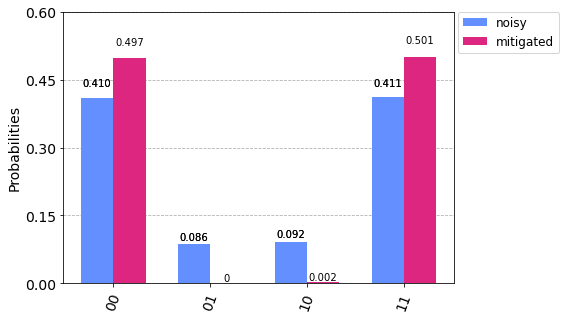

In [23]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

# Laboratory Seven

#### Laboratory Activity

For your laboratory activity repeat the model fitting with 3 qubits. This is a small change to the code. Your test circuit will now need to have three qubits. Start with the previous circuit that produced a Bell state and just add a X gate to the third qubit. Cut and paste the resulting histogram and submit it as your laboratory report. The report must be a PDF or PNG file.

1. Start with the previous circuit that produced a Bell state and just add a X gate to the third qubit.

In [38]:
qc = QuantumCircuit(3,3)
qc.h(0)
qc.cx(0,1)
qc.x(2)
qc.measure(qc.qregs[0],qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

{'000': 399, '001': 90, '010': 86, '011': 408, '100': 3742, '101': 796, '110': 805, '111': 3674}


2. Use the complete_meas_cal procedure to construct the circuits that we need to collect the data required for constructing the matrix.

In [31]:
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_000
        ░ ┌─┐      
q42_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q42_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q42_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c2: 3/════╩══╩══╩═
           0  1  2 

Circuit mcalcal_001
       ┌───┐ ░ ┌─┐      
q42_0: ┤ X ├─░─┤M├──────
       └───┘ ░ └╥┘┌─┐   
q42_1: ──────░──╫─┤M├───
             ░  ║ └╥┘┌─┐
q42_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c2: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_010
             ░ ┌─┐      
q42_0: ──────░─┤M├──────
       ┌───┐ ░ └╥┘┌─┐   
q42_1: ┤ X ├─░──╫─┤M├───
       └───┘ ░  ║ └╥┘┌─┐
q42_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c2: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_011
       ┌───┐ ░ ┌─┐      
q42_0: ┤ X ├─░─┤M├──────
       ├───┤ ░ └╥┘┌─┐   
q42_1: ┤ X ├─░──╫─┤M├───
       └───┘ ░  ║ └╥┘┌─┐
q42_2: ──────░──╫──╫─┤M├
             ░  ║  ║ └╥┘
 c2: 3/═════════╩══╩══╩═
                0  1  2 

Circuit mcalcal_100
             ░ ┌─┐      
q42_0: ──────░─┤

3. Run these circuits and fit the model. The CompleteMeasFitter procedure does the fitting

In [32]:
noise_model = get_noise(0.1)

backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.751 0.08  0.098 0.016 0.078 0.012 0.014 0.003]
 [0.078 0.728 0.015 0.087 0.005 0.072 0.    0.005]
 [0.075 0.004 0.716 0.079 0.008 0.002 0.077 0.01 ]
 [0.004 0.08  0.086 0.724 0.002 0.016 0.009 0.086]
 [0.078 0.009 0.008 0.    0.724 0.081 0.09  0.005]
 [0.01  0.091 0.    0.01  0.088 0.725 0.007 0.082]
 [0.003 0.    0.063 0.003 0.079 0.011 0.726 0.083]
 [0.001 0.008 0.014 0.081 0.016 0.081 0.077 0.726]]


4. Repeat the first section

In [35]:
qc = QuantumCircuit(3,3)
qc.h(0)
qc.cx(0,1)
qc.x(2)
qc.measure(qc.qregs[0],qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'000': 391, '001': 79, '010': 95, '011': 446, '100': 3669, '101': 805, '110': 787, '111': 3728}


5. Error Mitigation Model histogram

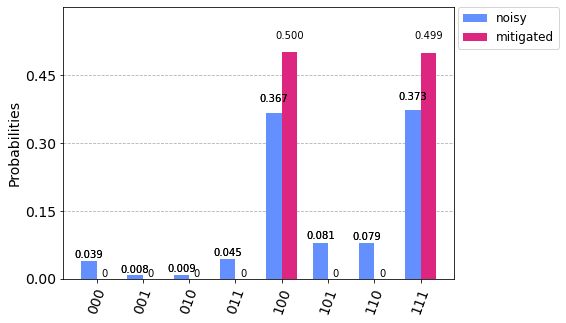

In [36]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])